In [17]:
%matplotlib notebook
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import requests

from config import gkey,api_key
from census import Census

def coordinates(loc):
    params = {"address": loc, "key":gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)
    place_geo = response.json()
    lat = place_geo['results'][0]["geometry"]['location']['lat']
    lng = place_geo['results'][0]["geometry"]['location']['lng']
    return lat, lng

c = Census(api_key, year=2018)
gmaps.configure(api_key = gkey)

In [2]:
df = pd.read_excel("Tables/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2018.xlsm")
df.dropna(inplace=True)
ls = []
for x in df["Agency name"]:
    if '3' in x:
        #print(x)
        ls.append(x[:-1])
    else:
        ls.append(x)
df["Agency name"] = ls
df

,State,Agency,Agency name,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
2,Alaska,Cities,Anchorage,1,0,0,0,0,0,0.0,0,1.0,0.0,291992.0
3,Alaska,Cities,Fairbanks,2,0,0,1,0,0,1.0,1,1.0,0.0,31635.0
4,Alaska,Cities,Juneau,0,2,0,0,0,0,0.0,0,2.0,0.0,31922.0
5,Alaska,Cities,Kotzebue,1,0,0,0,0,0,0.0,1,0.0,0.0,3273.0
9,Arizona,Cities,Coolidge,2,0,0,0,0,0,0.0,0,0.0,2.0,12815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,Wisconsin,Cities,Seymour,1,0,0,0,0,0,0.0,0,0.0,1.0,3460.0
2204,Wisconsin,Cities,Sheboygan,0,0,0,1,0,0,0.0,0,0.0,1.0,48195.0
2205,Wisconsin,Cities,Stevens Point,2,0,0,0,0,0,0.0,0,0.0,2.0,26233.0
2206,Wisconsin,Cities,Waterloo,0,1,0,0,0,0,1.0,0,0.0,0.0,3337.0


<IPython.core.display.Javascript object>


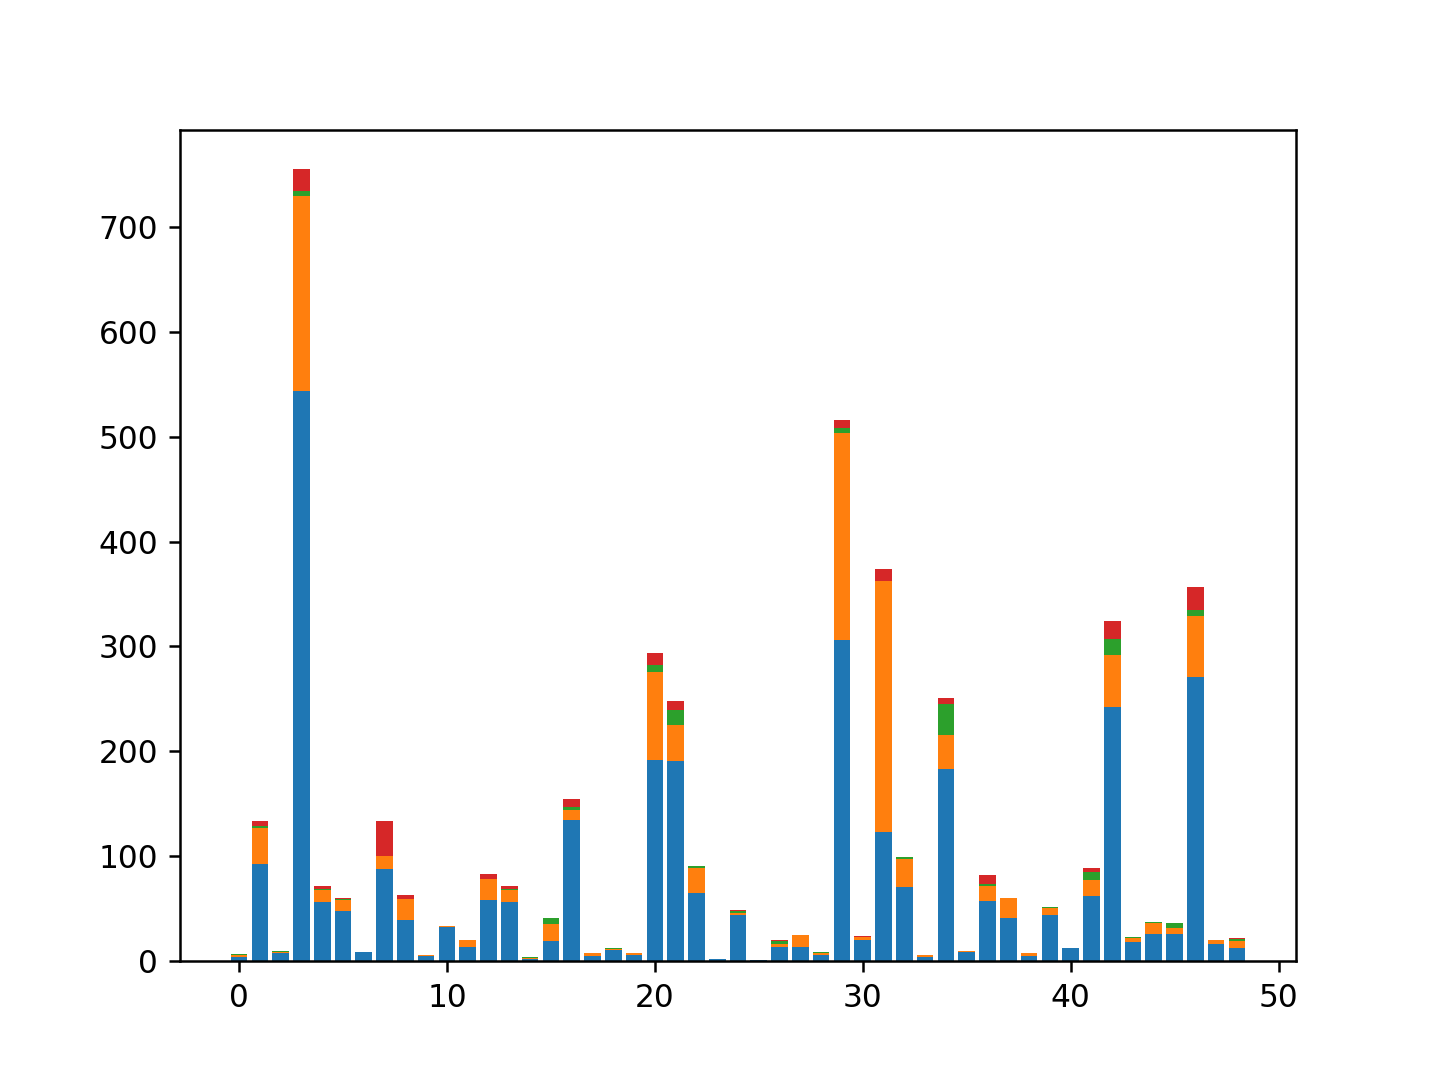

<BarContainer object of 49 artists>

In [34]:
dfg = df.groupby("State").sum()
dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity']]
dfg["Total"] = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"] + dfg["Gender"] + dfg["Gender identity"] + dfg["Disability"]


plt.bar(range(dfg.shape[0]),dfg["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfg["Religion"], bottom = dfg["Race/Ethnicity/Ancestry"])
plt.bar(range(dfg.shape[0]),dfg["Disability"], bottom = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"])
plt.bar(range(dfg.shape[0]),dfg["Gender"] + dfg["Gender identity"], bottom = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"] + dfg["Disability"])



In [36]:
dfg

,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,3rd quarter,4th quarter,Population,Total
State,,,,,,,,,,,
Alaska,4,2,0,1,0,0,1.0,4.0,0.0,358822.0,7
Arizona,93,34,37,2,2,3,51.0,35.0,36.0,4275253.0,134
Arkansas,8,1,1,1,0,0,4.0,1.0,2.0,342312.0,10
California,544,185,208,5,4,17,212.0,265.0,228.0,24792513.0,755
Colorado,56,12,19,1,0,3,15.0,21.0,19.0,2398112.0,72
Connecticut,48,10,9,1,1,0,9.0,18.0,22.0,1307105.0,60
Delaware,9,0,0,0,0,0,3.0,2.0,1.0,182449.0,9
District of Columbia,88,12,60,0,1,33,32.0,58.0,55.0,702455.0,134
Florida,39,20,25,0,0,4,20.0,31.0,20.0,4343839.0,63


In [16]:
# results saved to file locations.csv, not worth re-running outside of error
'''
df["Lat"] = ""
df["Lng"] = ""
for i,r in df.iterrows():
    st = r[2] + ',' + r[0]
    lat,lng = coordinates(st)
    df.loc[i,["Lat"]] = lat
    df.loc[i,["Lng"]] = lng

dfloc = df.loc[:,['State', 'Agency name', 'Lat', 'Lng']]

dfloc.to_csv("locations.csv")
'''

'\ndf["Lat"] = ""\ndf["Lng"] = ""\nfor i,r in df.iterrows():\n    st = r[2] + \',\' + r[0]\n    lat,lng = coordinates(st)\n    df.loc[i,["Lat"]] = lat\n    df.loc[i,["Lng"]] = lng\n\ndfloc = df.loc[:,[\'State\', \'Agency name\', \'Lat\', \'Lng\']]\n\ndfloc.to_csv("locations.csv")\n'

In [4]:
dfloc = pd.read_csv("locations.csv")
dfloc["Loc"] = dfloc["State"] + "," + dfloc["Agency name"]

df["Loc"] = df["State"] + "," + df["Agency name"]
dfa = pd.merge(df,dfloc,on=["Loc","Loc"])
dfa = dfa.loc[:,['Loc', 'Lat', 'Lng','Population', 'Race/Ethnicity/Ancestry',
       'Religion', 'Sexual Orientation', 'Disability', 'Gender',
       'Gender identity']]
dfa["Total"] = dfa["Race/Ethnicity/Ancestry"] + dfa["Religion"] + dfa["Gender"] + dfa["Gender identity"] + dfa["Disability"]
loc = dfa.loc[:,["Lat","Lng"]]

In [5]:
f = gmaps.figure()
l = gmaps.heatmap_layer(loc,weights=dfa["Total"])
f.add_layer(l)
f

Figure(layout=FigureLayout(height='420px'))

In [6]:
f1 = gmaps.figure()
l = gmaps.heatmap_layer(loc, weights=dfa["Population"])
f1.add_layer(l)
f1

Figure(layout=FigureLayout(height='420px'))

In [9]:
c.acs.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E", "B23025_005E"), {'for': 'state:*'})


[{'NAME': 'Minnesota',
  'B19013_001E': 68411.0,
  'B01003_001E': 5527358.0,
  'B01002_001E': 37.9,
  'B19301_001E': 36245.0,
  'B17001_002E': 547442.0,
  'B23025_005E': 119218.0,
  'state': '27'},
 {'NAME': 'Mississippi',
  'B19013_001E': 43567.0,
  'B01003_001E': 2988762.0,
  'B01002_001E': 37.2,
  'B19301_001E': 23434.0,
  'B17001_002E': 599795.0,
  'B23025_005E': 110036.0,
  'state': '28'},
 {'NAME': 'Missouri',
  'B19013_001E': 53560.0,
  'B01003_001E': 6090062.0,
  'B01002_001E': 38.5,
  'B19301_001E': 29537.0,
  'B17001_002E': 837930.0,
  'B23025_005E': 155958.0,
  'state': '29'},
 {'NAME': 'Montana',
  'B19013_001E': 52559.0,
  'B01003_001E': 1041732.0,
  'B01002_001E': 39.8,
  'B19301_001E': 29765.0,
  'B17001_002E': 139063.0,
  'B23025_005E': 22433.0,
  'state': '30'},
 {'NAME': 'Nebraska',
  'B19013_001E': 59116.0,
  'B01003_001E': 1904760.0,
  'B01002_001E': 36.4,
  'B19301_001E': 31101.0,
  'B17001_002E': 213790.0,
  'B23025_005E': 36545.0,
  'state': '31'},
 {'NAME': 'Nev

In [10]:
from census_vars import censuskey
censuskey

{'income': 'B19013_001E',
 'income_per_capita': 'B19301_001E',
 'employment_labor_force': 'B23025_002E',
 'employment_not_labor_force': 'B23025_007E',
 'employment_civilian_labor_force': 'B23025_003E',
 'employment_employed': 'B23025_004E',
 'employment_unemployed': 'B23025_005E',
 'employment_armed_forces': 'B23025_006E',
 'employment_male_management_business_science_and_arts_occupations': 'C24010_003E',
 'employment_male_management_business_and_financial_occupations': 'C24010_004E',
 'employment_male_management_occupations': 'C24010_005E',
 'employment_male_business_and_financial_operations_occupations': 'C24010_006E',
 'employment_male_computer_engineering_and_science_occupations': 'C24010_007E',
 'employment_male_computer_and_mathematical_occupations': 'C24010_008E',
 'employment_male_architecture_and_engineering_occupations': 'C24010_009E',
 'employment_male_life_physical_and_social_science_occupations': 'C24010_010E',
 'employment_male_education_legal_community_service_arts_and_m

In [35]:
dfloc

,Unnamed: 0,State,Agency name,Lat,Lng,Loc
0,2,Alaska,Anchorage,61.218056,-149.900278,"Alaska,Anchorage"
1,3,Alaska,Fairbanks,64.837778,-147.716389,"Alaska,Fairbanks"
2,4,Alaska,Juneau,58.301944,-134.419722,"Alaska,Juneau"
3,5,Alaska,Kotzebue,66.898333,-162.596667,"Alaska,Kotzebue"
4,9,Arizona,Coolidge,32.977839,-111.517624,"Arizona,Coolidge"
...,...,...,...,...,...,...
1458,2203,Wisconsin,Seymour,44.514988,-88.330380,"Wisconsin,Seymour"
1459,2204,Wisconsin,Sheboygan,43.750828,-87.714530,"Wisconsin,Sheboygan"
1460,2205,Wisconsin,Stevens Point,44.523579,-89.574563,"Wisconsin,Stevens Point"
1461,2206,Wisconsin,Waterloo,43.183884,-88.988442,"Wisconsin,Waterloo"
